# Example calculation of observatory position angles and North orientation on EXCAM

- Get the position angle of the EXCAM data array +Y axis with respect to celestial North, for a given target and set of dates
- Plot the projected North vector and the Observatory axes on the EXCAM data array
- Apply a roll angle offset to the observatory, recompute the position angles, and plot the new North orientation on EXCAM.   

In [1]:
from roman_pointing.roman_pointing import (calcRomanAngles, getL2Positions, 
                                           getRomanPositionAngle, getEXCAMPositionAngle, applyRollAngle)
import astropy.units as u
from astropy.time import Time
from astroquery.simbad import Simbad
from astroquery.jplhorizons import Horizons
from astropy.coordinates import (
    SkyCoord,
    Distance,
    get_body_barycentric,
    get_body,
    BarycentricMeanEcliptic,
    ICRS
)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Define some helper functions for plotting 

In [2]:
def bowtie_xys():
    #returns boundary points in xy coordinates, with units of arcsec, for nominal and rotated bowtie FOVs
    open_ang = 65 * u.deg
    ctr_ang = np.array([90, 270, 30, 210])*u.deg # [nominal 2, rotated 2]
    r_in_mas = [172.8, 191.2] # for B2 and B3 
    r_out_mas = [524.2, 579.8] # for B2 and B3
    num_pts = 50

    xs = np.zeros([4, num_pts*2+1])
    ys = np.zeros([4, num_pts*2+1])

    for ct_bowtie in range(1):
        for ct in range(len(ctr_ang)):
            arc = np.linspace(start=ctr_ang[ct]-open_ang/2, 
                                       stop=ctr_ang[ct]+open_ang/2, num=num_pts)
            thetas = np.hstack([arc, np.flip(arc), arc[0]]) 
            rads = np.array(num_pts * [r_in_mas[ct_bowtie]] + num_pts * [r_out_mas[ct_bowtie]] + [r_in_mas[ct_bowtie]])

            xs[ct,:] = rads * np.cos(thetas) / 1000
            ys[ct,:] = rads * np.sin(thetas) / 1000

    return(xs, ys)

In [3]:
def gen_sky_plot(excam_pa_y, my_pa=None, my_rho=None):
    # excam_pa_y = position angle of Y with respect to North. Must have astropy units (eg: 50*u.deg)
    # my_pa = position angle of my companion with respect to North, with astropy units
    # my_rho = separation of my companion in units of arcsec (no astropy units)
    
    fig, ax = plt.subplots(figsize=(8, 8))

    obs_z_angle = -60 * u.deg  # Observatory +Z axis is fixed with respect to the EXCAM array
    obs_y_angle = 30 * u.deg  # Observatory +Y axis is fixed with respect to the EXCAM array
    north_angle = 90 * u.deg - excam_pa_y  # Orient the projected North vector based on the position angle of EXCAM +Y
    east_angle = 180 * u.deg - excam_pa_y # EXCAM is North Up / East Left handedness

    # Define vector components (unit vectors)
    north_x = np.cos(north_angle)
    north_y = np.sin(north_angle)
    east_x = np.cos(east_angle)
    east_y = np.sin(east_angle)
    obsz_x = np.cos(obs_z_angle)
    obsz_y = np.sin(obs_z_angle)
    obsy_x = np.cos(obs_y_angle)
    obsy_y = np.sin(obs_y_angle)

    # define bowtie boundary
    [spec_xs, spec_ys] = bowtie_xys()

    # Plot vectors
    ax.quiver(0, 0, north_x, north_y, angles='xy', scale_units='xy', scale=1,
              color='red', width=0.01, label='North')
    ax.quiver(0, 0, east_x, east_y, angles='xy', scale_units='xy', scale=1,
              color='red', width=0.005, label='East')
    ax.quiver(0, 0, obsz_x, obsz_y, angles='xy', scale_units='xy', scale=1,
              color='blue', width=0.005, label='Observatory +Z')
    ax.quiver(0, 0, obsy_x, obsy_y, angles='xy', scale_units='xy', scale=1,
              color='blue', width=0.005, label='Observatory +Y')
    ax.quiver(0, 0, 1.1, 0, angles='xy', scale_units='xy', scale=1,
              color='black', width=0.005, label='EXCAM +X')
    ax.quiver(0, 0, 0, 1.1, angles='xy', scale_units='xy', scale=1,
              color='black', width=0.005, label='EXCAM +Y')

    # Plot bowties
    for ct in range(4):
        if ct<2:
            plt.plot(spec_xs[ct], spec_ys[ct], color='gray', label='nominal bowtie')
        else:
            plt.plot(spec_xs[ct], spec_ys[ct], color='lightgray', label='rotated bowtie')
            
    # plot my companion
    if my_rho is not None:
        comp_x = my_rho * np.cos(my_pa + north_angle)
        comp_y = my_rho * np.sin(my_pa + north_angle)
        ax.scatter(comp_x, comp_y, marker='d', s=100, c='orange', edgecolors='k', label='companion')


    # Set up the plot
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3)
    # Place text labels at arrow tips
    ax.text(north_x * 1.1, north_y * 1.1, 'North', color='red',
            ha='center', va='center', fontsize=12, fontweight='bold')
    ax.text(east_x * 1.1, east_y * 1.1, 'East', color='red',
            ha='center', va='center', fontsize=12, fontweight='bold')
    ax.text(obsz_x * 1.1 - 0.1, obsz_y * 1.1, 'Observatory +Z\nRoman SIAF +v3', color='blue',
            ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(obsy_x * 1.1 - 0.1, obsy_y * 1.1, 'Observatory +Y\nRoman SIAF +v2', color='blue',
            ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(1.0, -0.1, 'EXCAM +X', color='black',
            ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(0.2, 1.0, 'EXCAM +Y', color='black',
            ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(spec_xs[0,int(spec_xs.shape[1]/2)] * 1.1, spec_ys[0,int(spec_ys.shape[1]/2)] * 1.1, 
            'nominal\nbowtie', color='gray', ha='right', va='center', fontsize=12, fontweight='bold')
    ax.text(spec_xs[3,int(spec_xs.shape[1]/1.5)] * 1.1, spec_ys[3,int(spec_ys.shape[1]/1.5)] * 1.1, 
            'rotated\nbowtie', color='darkgray', ha='right', va='center', fontsize=12, fontweight='bold')


    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f'EXCAM North orientation for {target_str}\nat {ts_targ[0]}\nNominal roll angle')

    plt.show()

## Query Star Data

First, query information about the target (47 UMa)

In [4]:
# generate Simbad object and specify returns
simbad = Simbad()
simbad.add_votable_fields("pmra", "pmdec", "plx_value", "rvz_radvel")

In [5]:
# query for 47 Uma and then build skycoord object
target_str = "47 UMa"
res = simbad.query_object(target_str)
target = SkyCoord(
    res["ra"].value.data[0],
    res["dec"].value.data[0],
    unit=(res["ra"].unit, res["dec"].unit),
    frame="icrs",
    distance=Distance(parallax=res["plx_value"].value.data[0] * res["plx_value"].unit),
    pm_ra_cosdec=res["pmra"].value.data[0] * res["pmra"].unit,
    pm_dec=res["pmdec"].value.data[0] * res["pmdec"].unit,
    radial_velocity=res["rvz_radvel"].value.data[0] * res["rvz_radvel"].unit,
    equinox="J2000",
    obstime="J2000",
).transform_to(BarycentricMeanEcliptic)

## Compute Discrete Pointings

Now, we can compute the pointing angles for each.  For these calculations, we are placing the observatory at L2.

In [6]:
t_str = ["2027-06-01T00:00:00.0"]
t0 = Time(t_str, format="isot", scale="utc")
ts_targ = t0 + [0, 10, 20, 30] * u.day

sun_ang_targ, yaw_targ, pitch_targ, B_C_I_targ = calcRomanAngles(
    target, ts_targ, getL2Positions(ts_targ)
)

In [7]:
sun_ang_targ.to_value(u.deg), yaw_targ.to_value(u.deg), pitch_targ.to_value(u.deg)

(array([80.71019838, 72.59562106, 64.65181639, 56.96613757]),
 array([121.51199148, 122.71280213, 124.5907875 , -51.99105335]),
 array([ -9.28980162, -17.40437894, -25.34818361, -33.03386243]))

### Position angle of the observatory +Z axis with respect to North, projected onto the instrument focal plane

In [8]:
PA_Z = getRomanPositionAngle(B_C_I_targ)

In [9]:
np.rad2deg(PA_Z)

<Quantity [-69.02686622, -74.25633191, -79.95234682, -86.43113911] deg>

### Position angle of the EXCAM +Y axis with respect to North, projected onto the instrument focal plane

In [10]:
PA_EXCAM_Y = getEXCAMPositionAngle(B_C_I_targ)

In [11]:
np.rad2deg(PA_EXCAM_Y)

<Quantity [80.97313378, 75.74366809, 70.04765318, 63.56886089] deg>

### Plot the orientation of North and Observatory axes on the EXCAM data array at the first date

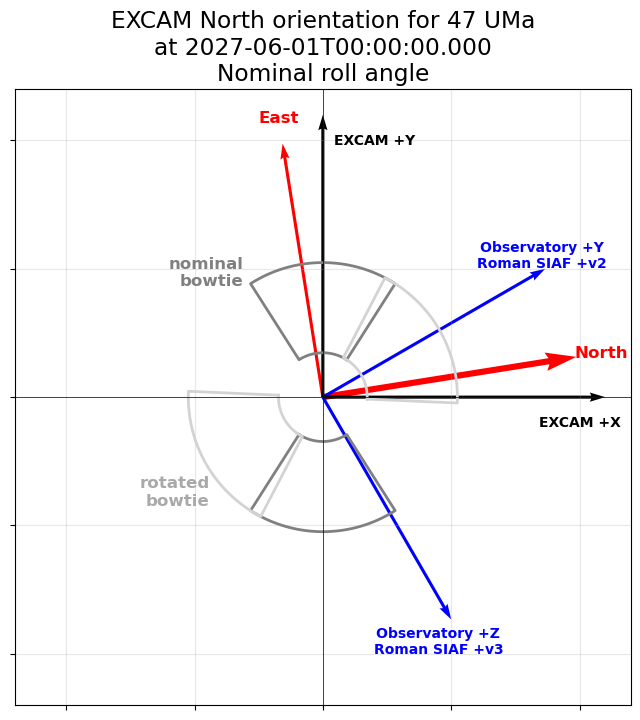

In [12]:
gen_sky_plot(PA_EXCAM_Y[0])  

### Visualize whether your favorite companion is in the bowtie

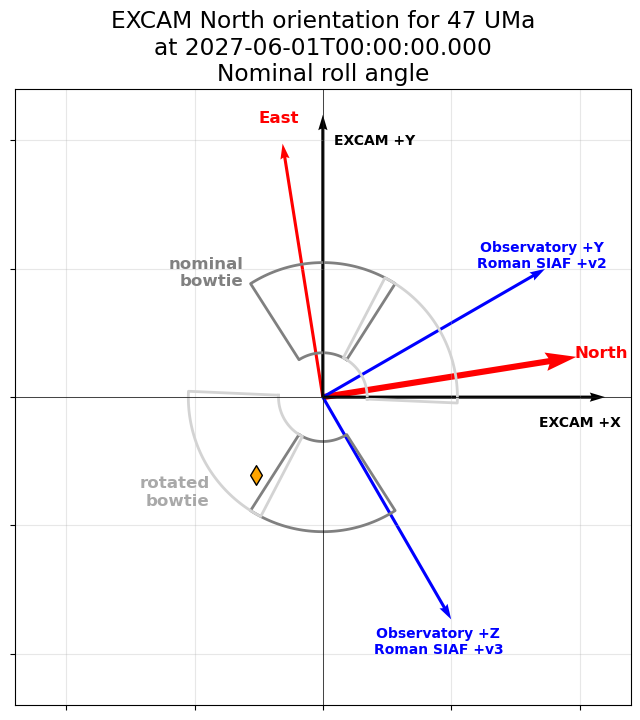

In [13]:
gen_sky_plot(PA_EXCAM_Y[0], my_rho=0.4, my_pa=220*u.deg)  

### Apply an observatory roll angle offset of +15 degrees from the nominal roll at each date.  Recompute the body-centered vectors and position angles. 

In [14]:
roll_angles = [15.0 * u.deg for t in ts_targ]

In [15]:
B_C_I_targ_plusroll = applyRollAngle(B_C_I_targ, roll_angles)

In [16]:
PA_Z_plusroll = getRomanPositionAngle(B_C_I_targ_plusroll)
PA_EXCAM_Y_plusroll = getEXCAMPositionAngle(B_C_I_targ_plusroll)

In [17]:
np.rad2deg(PA_Z_plusroll), np.rad2deg(PA_EXCAM_Y_plusroll)

(<Quantity [ -84.02686622,  -89.25633191,  -94.95234682, -101.43113911] deg>,
 <Quantity [65.97313378, 60.74366809, 55.04765318, 48.56886089] deg>)

### Re-do first date plot with the roll angle offset applied

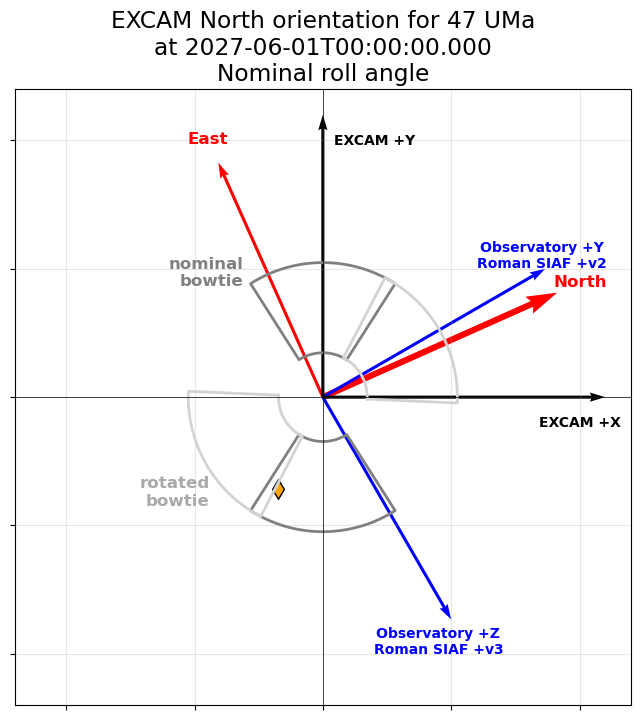

In [18]:
gen_sky_plot(PA_EXCAM_Y_plusroll[0], my_rho=0.4, my_pa=220*u.deg) 